# Music Analysis

In [1]:
import os

import time

import warnings
warnings.filterwarnings("ignore")      

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [2]:
PATH_DATA = '../DL_DATA/MUSIC/data.csv'

In [3]:
df = pd.read_csv(PATH_DATA)
df.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [4]:
df = df.drop("Unnamed: 0", axis="columns")

In [5]:
print(f'Size of dataset:{df.shape}')

Size of dataset:(2017, 16)


## Caracteristic Distributions

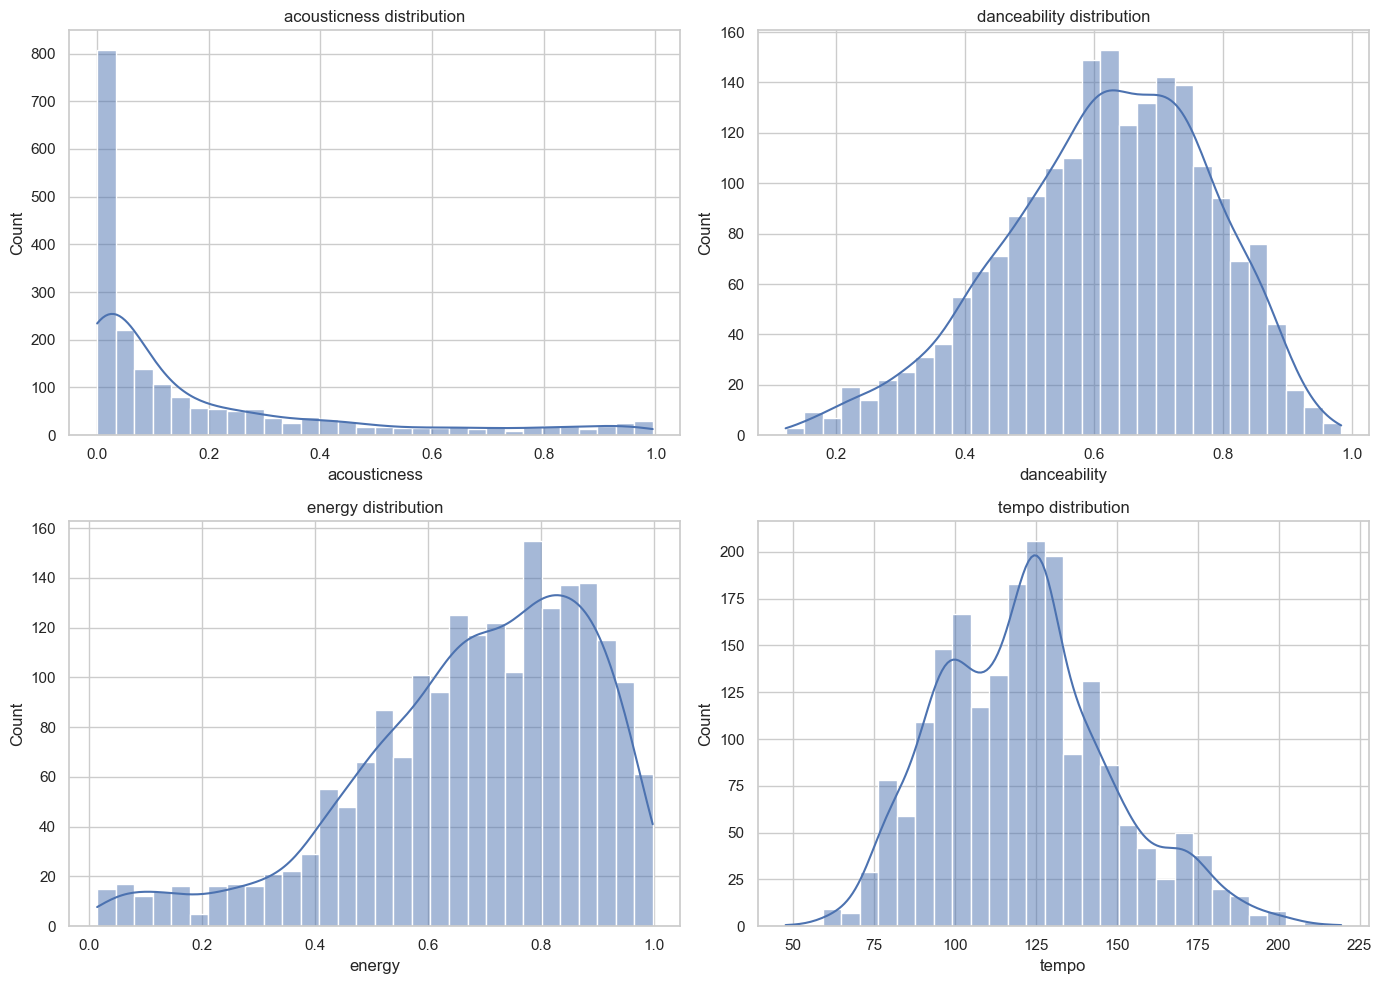

In [6]:
# Lista de características para visualizar
features_to_plot = ['acousticness', 'danceability', 'energy', 'tempo']

# Creando subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

for i, feature in enumerate(features_to_plot):
    row = i // 2
    col = i % 2
    sns.histplot(df[feature], kde=True, ax=axes[row, col], bins=30)
    axes[row, col].set_title(f'{feature} distribution')

plt.tight_layout()
plt.show()

## Relationships between Characteristics

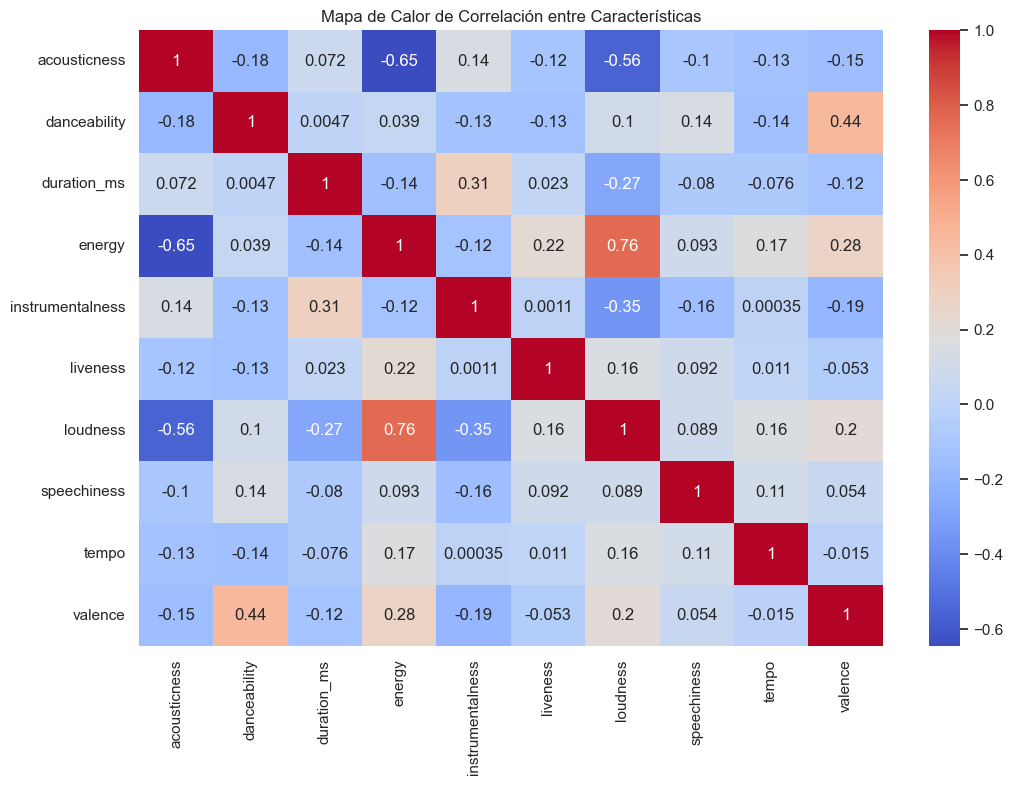

In [7]:
# Seleccionando las características numéricas para la correlación
correlation_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 
                        'instrumentalness', 'liveness', 'loudness', 'speechiness', 
                        'tempo', 'valence']

# Calculando la matriz de correlación
correlation_matrix = df[correlation_features].corr()

# Creando un mapa de calor para visualizar la correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación entre Características')
plt.show()


## Artists Analysis

In [8]:
artist_counts = df['artist'].value_counts().head(10)

artist_features = ['acousticness', 'danceability', 'energy', 'tempo', 'valence']

In [9]:
df['artist'].value_counts().head(10)

artist
Drake              16
Rick Ross          13
Disclosure         12
WALK THE MOON      10
Backstreet Boys    10
Crystal Castles     9
FIDLAR              9
Future              8
Fall Out Boy        8
Skrillex            8
Name: count, dtype: int64

In [10]:
type(artist_counts)

pandas.core.series.Series

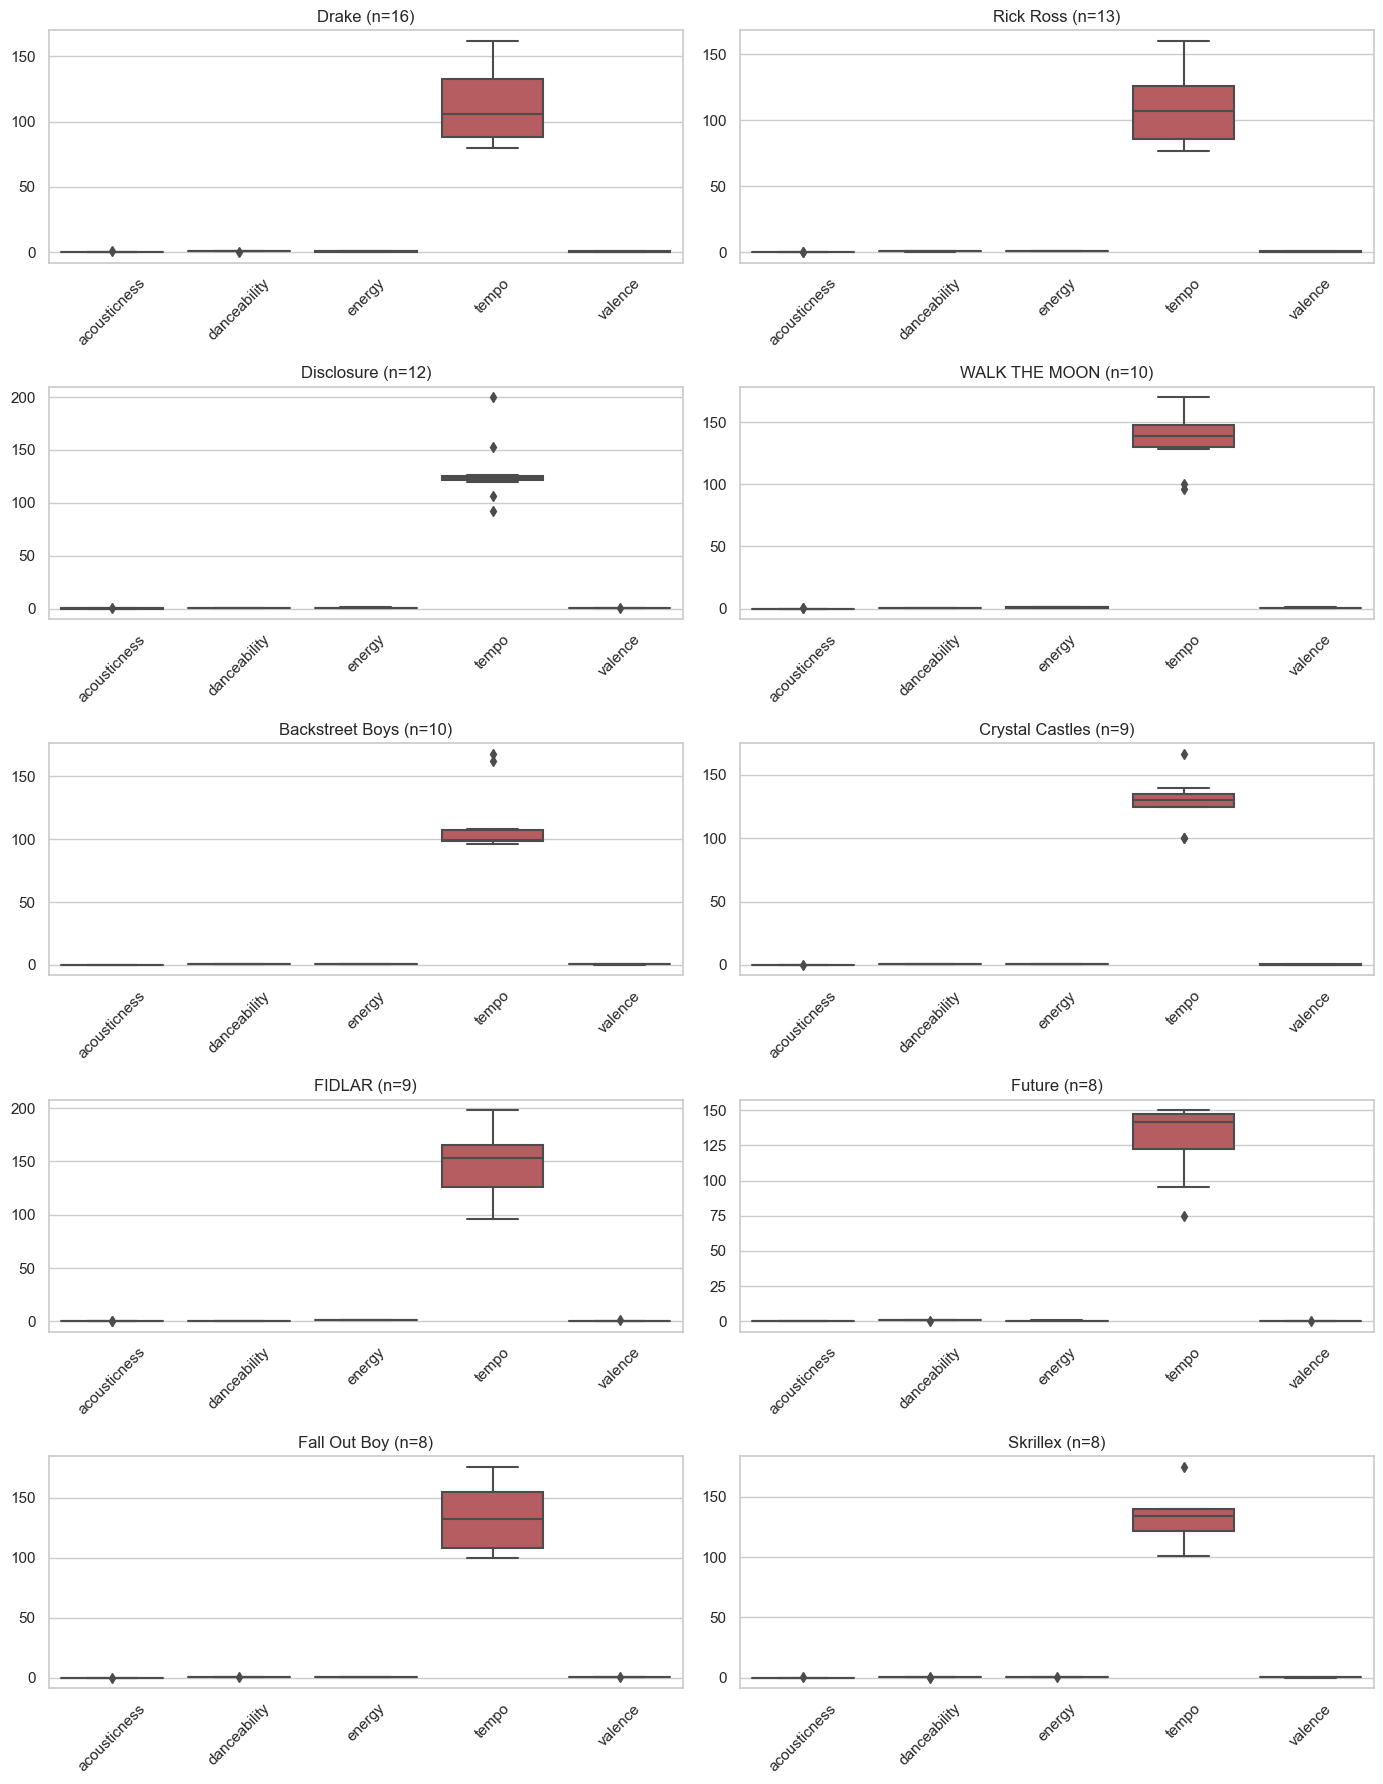

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 18))

for i, (artist, count) in enumerate(artist_counts.items()):
    row = i // 2
    col = i % 2
    artist_data = df[df['artist'] == artist][artist_features]
    sns.boxplot(data=artist_data, ax=axes[row, col])
    axes[row, col].set_title(f'{artist} (n={count})')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Song Recommender

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
def recommend_songs(song_title, n_recommendations=5):
    song_index = df[df['song_title'] == song_title].index[0]
    
    features_for_similarity = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                               'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
    
    similarity_matrix = cosine_similarity(df[features_for_similarity])
    
    similar_songs = list(enumerate(similarity_matrix[song_index]))
    similar_songs_sorted = sorted(similar_songs, key=lambda x: x[1], reverse=True)[1:n_recommendations+1]
    
    recommended_songs = [df.iloc[i[0]]['song_title'] for i in similar_songs_sorted]
    return recommended_songs

In [14]:
song_title_to_test = "Mask Off"
recommendations = recommend_songs(song_title_to_test)
recommendations

['Mask Off',
 "I Don't Sell Molly No More",
 'Mercy',
 'Females Welcomed (feat. Reija Lee)',
 'Dopeman']

In [15]:
song_title_to_test = "Dopeman"
recommendations = recommend_songs(song_title_to_test)
recommendations

['Bounce It',
 'Rhythm of Devotion',
 'Batuque (Jeremy Sole & Atropolis Remix)',
 'Females Welcomed (feat. Reija Lee)',
 'Hotline Bling']

## Classification of Songs Based on Characteristics (Supervised Learning)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Características y etiquetas
X = df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
y = df['target']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1613, 9), (404, 9), (1613,), (404,))

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [22]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [23]:
class SongClassifier(nn.Module):
    def __init__(self):
        super(SongClassifier, self).__init__()
        self.fc1 = nn.Linear(9, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [24]:
model = SongClassifier()
model.to(device)

SongClassifier(
  (fc1): Linear(in_features=9, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [29]:
learning_rate = 0.001
epochs = 200

In [30]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# for epoch in range(epochs):
#     for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         # Forward pass
#         y_pred = model(X_batch)
#         loss = criterion(y_pred, y_batch)
        
#         # Backward pass y optimización
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.6542317867279053
Epoch 2/100, Loss: 0.7095421552658081
Epoch 3/100, Loss: 0.5533425807952881
Epoch 4/100, Loss: 0.7087072134017944
Epoch 5/100, Loss: 0.6572476625442505
Epoch 6/100, Loss: 0.6950162053108215
Epoch 7/100, Loss: 0.6869380474090576
Epoch 8/100, Loss: 0.6904447078704834
Epoch 9/100, Loss: 0.6993058323860168
Epoch 10/100, Loss: 0.8541378378868103
Epoch 11/100, Loss: 0.6525465846061707
Epoch 12/100, Loss: 0.5941546559333801
Epoch 13/100, Loss: 0.6679907441139221
Epoch 14/100, Loss: 0.6601227521896362
Epoch 15/100, Loss: 0.6629816293716431
Epoch 16/100, Loss: 0.584800124168396
Epoch 17/100, Loss: 0.7554789185523987
Epoch 18/100, Loss: 0.628559947013855
Epoch 19/100, Loss: 0.763451874256134
Epoch 20/100, Loss: 0.5966209769248962
Epoch 21/100, Loss: 0.7197576761245728
Epoch 22/100, Loss: 0.5671045780181885
Epoch 23/100, Loss: 0.6863905191421509
Epoch 24/100, Loss: 0.7008211612701416
Epoch 25/100, Loss: 0.6622257232666016
Epoch 26/100, Loss: 0.607703924179077

In [35]:
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(y_pred.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Accuracy: {train_accuracies[-1]}%')


Epoch 1/100, Loss: 0.5793177555589115, Accuracy: 1561.0043397396157%
Epoch 2/100, Loss: 0.5828554127730575, Accuracy: 1565.7160570365777%
Epoch 3/100, Loss: 0.589140886185216, Accuracy: 1558.6484810911345%
Epoch 4/100, Loss: 0.5896084109942118, Accuracy: 1565.7160570365777%
Epoch 5/100, Loss: 0.5893516470404232, Accuracy: 1563.3601983880967%
Epoch 6/100, Loss: 0.5811689881717458, Accuracy: 1564.5381277123372%
Epoch 7/100, Loss: 0.5790413805082733, Accuracy: 1563.3601983880967%
Epoch 8/100, Loss: 0.5889937795844733, Accuracy: 1561.0043397396157%
Epoch 9/100, Loss: 0.5813702578638115, Accuracy: 1561.0043397396157%
Epoch 10/100, Loss: 0.5838539091979756, Accuracy: 1558.6484810911345%
Epoch 11/100, Loss: 0.5822281925117269, Accuracy: 1559.826410415375%
Epoch 12/100, Loss: 0.5814903501202079, Accuracy: 1561.0043397396157%
Epoch 13/100, Loss: 0.5899951183328441, Accuracy: 1559.826410415375%
Epoch 14/100, Loss: 0.5820572785302704, Accuracy: 1557.470551766894%
Epoch 15/100, Loss: 0.58149930250

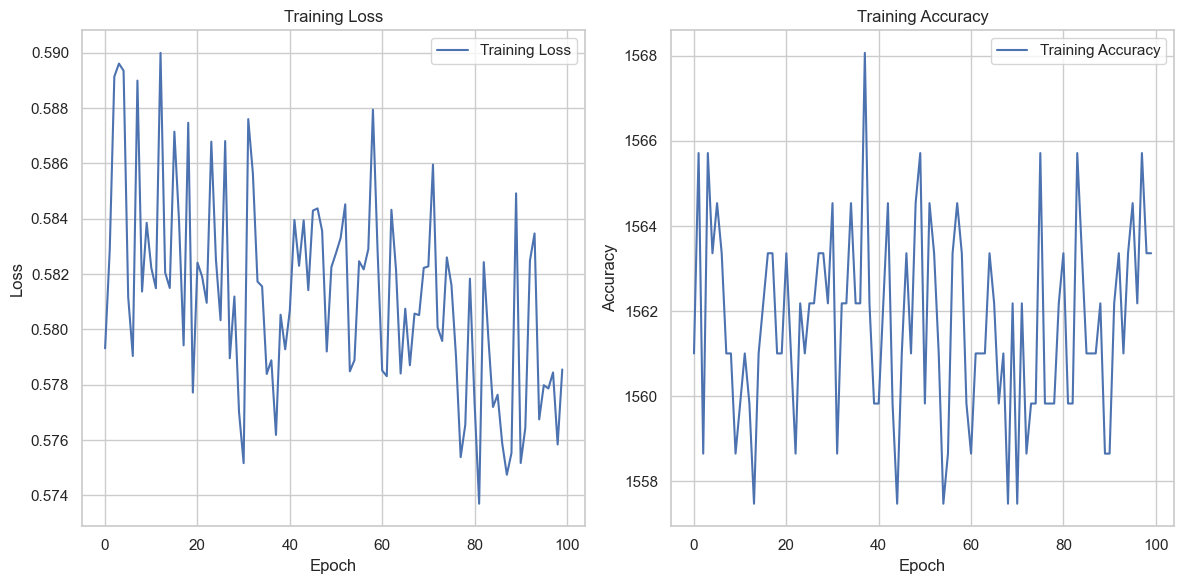

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
model.eval()
with torch.no_grad():
    correct = 0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        predicted = (y_pred > 0.5).float()
        correct += (predicted == y_batch).sum().item()
    
    accuracy = correct / len(y_test)
    print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 68.07%
